In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e12/sample_submission.csv
/kaggle/input/playground-series-s4e12/train.csv
/kaggle/input/playground-series-s4e12/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime

from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score 
from sklearn.metrics import accuracy_score, roc_curve, auc, mean_squared_error, r2_score 

import warnings
warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv',index_col='id' )
df_test = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv',index_col='id' )
df_sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e12/sample_submission.csv')

In [4]:
y = df_train['Premium Amount']
X = df_train.drop(columns=['Premium Amount']) 

In [5]:
df_train.isna().sum()

Age                      18705
Gender                       0
Annual Income            44949
Marital Status           18529
Number of Dependents    109672
Education Level              0
Occupation              358075
Health Score             74076
Location                     0
Policy Type                  0
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Policy Start Date            0
Customer Feedback        77824
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
dtype: int64

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1200000 entries, 0 to 1199999
Data columns (total 20 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Age                   1181295 non-null  float64
 1   Gender                1200000 non-null  object 
 2   Annual Income         1155051 non-null  float64
 3   Marital Status        1181471 non-null  object 
 4   Number of Dependents  1090328 non-null  float64
 5   Education Level       1200000 non-null  object 
 6   Occupation            841925 non-null   object 
 7   Health Score          1125924 non-null  float64
 8   Location              1200000 non-null  object 
 9   Policy Type           1200000 non-null  object 
 10  Previous Claims       835971 non-null   float64
 11  Vehicle Age           1199994 non-null  float64
 12  Credit Score          1062118 non-null  float64
 13  Insurance Duration    1199999 non-null  float64
 14  Policy Start Date     1200000 non-null 

In [7]:
numerical_columns = X.select_dtypes(include=['number']).columns
categorical_columns = X.select_dtypes(include=['object']).columns

In [8]:
numerical_columns

Index(['Age', 'Annual Income', 'Number of Dependents', 'Health Score',
       'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration'],
      dtype='object')

In [9]:
categorical_columns

Index(['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location',
       'Policy Type', 'Policy Start Date', 'Customer Feedback',
       'Smoking Status', 'Exercise Frequency', 'Property Type'],
      dtype='object')

In [10]:

categorical_columns = categorical_columns.drop('Policy Start Date')

In [11]:
df_train['Annual Income'].quantile(0.025)

735.0

### Exploratory Data Analysis

In [12]:
# Calculate missing percentages
categorical_missing_percentages = df_train[categorical_columns].isnull().sum() / len(df_train) * 100
categorical_missing_percentages = categorical_missing_percentages[categorical_missing_percentages > 0]

categorical_missing_percentages

Marital Status        1.544083
Occupation           29.839583
Customer Feedback     6.485333
dtype: float64

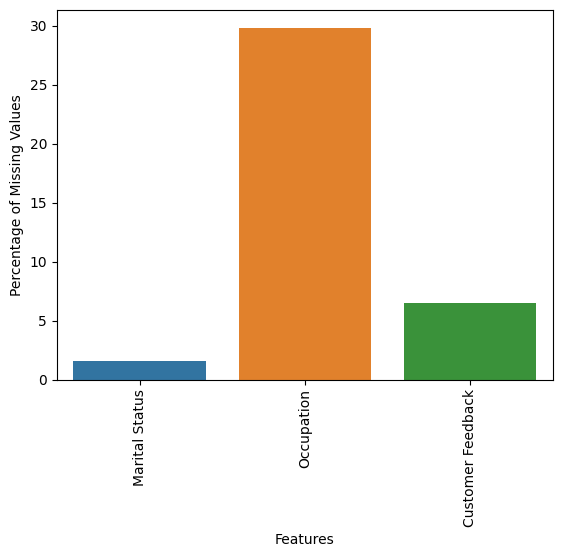

In [13]:
# Create the barplot
sns.barplot(x=categorical_missing_percentages.index, y=categorical_missing_percentages.values)

# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Label the axes
plt.xlabel('Features')
plt.ylabel('Percentage of Missing Values')

# Display the plot
plt.show()

In [14]:
# Calculate missing percentages for numerical columns
numerical_missing_percentages = df_train[numerical_columns].isnull().sum() / len(df_train) * 100
numerical_missing_percentages = numerical_missing_percentages[numerical_missing_percentages > 0]

numerical_missing_percentages

Age                      1.558750
Annual Income            3.745750
Number of Dependents     9.139333
Health Score             6.173000
Previous Claims         30.335750
Vehicle Age              0.000500
Credit Score            11.490167
Insurance Duration       0.000083
dtype: float64

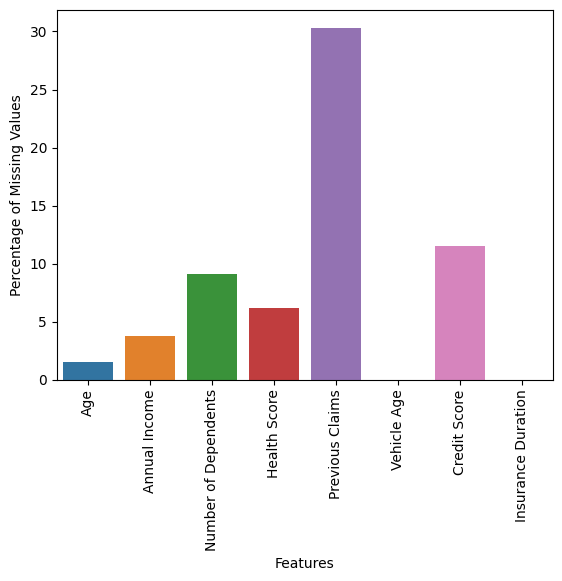

In [15]:
# Create the barplot
sns.barplot(x=numerical_missing_percentages.index, y=numerical_missing_percentages.values)

# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Label the axes
plt.xlabel('Features')
plt.ylabel('Percentage of Missing Values')

# Display the plot
plt.show()

### Exploratory Data Analytics

#### Target Variable Analysis

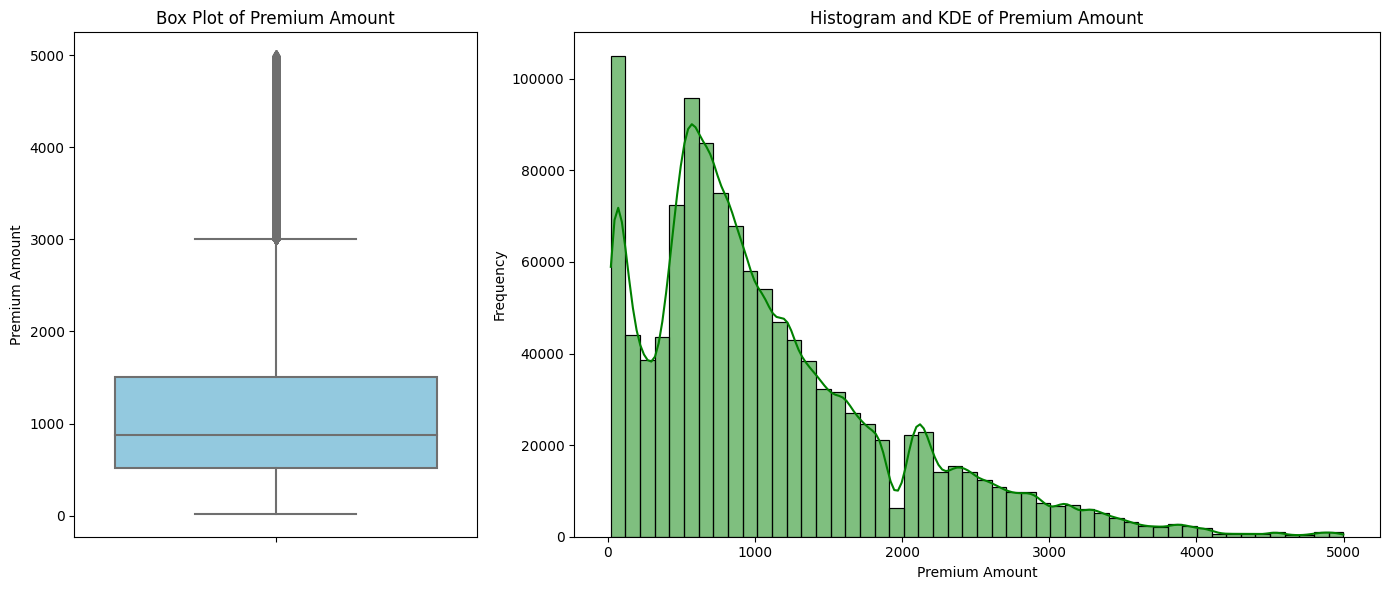

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 2]})

# Box plot on the left
sns.boxplot(y=df_train['Premium Amount'], ax=axes[0], color='skyblue')
axes[0].set(title='Box Plot of Premium Amount', xlabel='', ylabel='Premium Amount')

# Histogram with KDE on the right
sns.histplot(df_train['Premium Amount'], kde=True, bins=50, ax=axes[1], color='green')
axes[1].set(title='Histogram and KDE of Premium Amount', xlabel='Premium Amount', ylabel='Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

### Categorical Variables Distribution with Premium Amount

In [ ]:

for column in categorical_columns:
    print(f'Column: {column}')
    print(df_train[column].value_counts())

In [ ]:
df_train[categorical_columns].isna().sum()

In [ ]:
# Using sns.displot for faceted histogram
sns.displot(
    data=df_train,
    x='Premium Amount',
    col='Marital Status',
    kde=True,  # Add KDE curve for smoothness
    col_wrap=3,  # Number of facets per row (adjust as needed)
    bins=10,  # Number of bins
    height=4,  # Height of each facet
    aspect=1.2,  # Aspect ratio of each facet
    palette = 'Set2'# Optional color
)

# Adding a title to the entire plot
plt.subplots_adjust(top=0.9)
plt.suptitle('Distribution of Premium Amount Faceted by Marital Status', fontsize=16)

# Show the plot
plt.show()

In [ ]:
# Using sns.displot for faceted histogram
sns.displot(
    data=df_train,
    x='Premium Amount',
    col='Occupation',
    kde=True,  # Add KDE curve for smoothness
    col_wrap=3,  # Number of facets per row (adjust as needed)
    bins=10,  # Number of bins
    height=4,  # Height of each facet
    aspect=1.2,  # Aspect ratio of each facet
    palette = 'Set2'# Optional color
)

# Adding a title to the entire plot
plt.subplots_adjust(top=0.9)
plt.suptitle('Distribution of Premium Amount Faceted by Occupation', fontsize=16)

# Show the plot
plt.show()

In [ ]:
# Using sns.displot for faceted histogram
sns.displot(
    data=df_train,
    x='Premium Amount',
    col='Education Level',
    kde=True,  # Add KDE curve for smoothness
    col_wrap=3,  # Number of facets per row (adjust as needed)
    bins=10,  # Number of bins
    height=4,  # Height of each facet
    aspect=1.2,  # Aspect ratio of each facet
    palette = 'Set2'# Optional color
)

# Adding a title to the entire plot
plt.subplots_adjust(top=0.9)
plt.suptitle('Distribution of Premium Amount Faceted by Education Level', fontsize=16)

# Show the plot
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 2]})

# Box plot on the left
sns.boxplot(y=df_train['Annual Income'], ax=axes[0], color='skyblue')
axes[0].set(title='Box Plot of Annual Income', xlabel='', ylabel='Annual Income')

# Histogram with KDE on the right
sns.histplot(df_train['Annual Income'], kde=True, bins=15, ax=axes[1], color='green')
axes[1].set(title='Histogram and KDE of Annual Income', xlabel='Annual Income', ylabel='Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Line plot with seaborn
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_train,
    x='Number of Dependents', 
    palette='viridis',         # Optional color palette
    linewidth=2                # Line thickness
)

# Adding labels and title
plt.title(' Number of Dependents Distribution', fontsize=16)  
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Line plot with seaborn
plt.figure(figsize=(12, 6))
sns.histplot(
    x=df_train['Credit Score'], 
    palette='viridis',         # Optional color palette
    kde=True,
    bins=10
)

# Adding labels and title
plt.title(' Credit Score Distribution', fontsize=16)  
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:

# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_train,
    x='Policy Type',
    y='Premium Amount',
    ci=None,  # Remove confidence intervals for cleaner visualization
    palette='Set2'
)

# Adding labels and title
plt.title('Average Premium Amount by Policy Type', fontsize=16)
plt.xlabel('Policy Type', fontsize=14)
plt.ylabel('Average Premium Amount', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

### Feature Engineering

#### Categorical Column Missing Value Impute

In [17]:
class HandleOutliers(BaseEstimator, TransformerMixin):
    def __init__(self, p_min=0.01, p_max=0.99):
        self.p_min = p_min
        self.p_max = p_max

    def fit(self, X, y=None):
        # Fit method is required by the estimator interface but we don't need to do anything here
        return self

    def transform(self, X):
        X = pd.DataFrame(X)  # Ensure it's a DataFrame for easy processing
        for column in X.columns:
            # Calculate the min and max percentiles
            p_min_value = X[column].quantile(self.p_min)
            p_max_value = X[column].quantile(self.p_max)

            # Replace values below min percentile and above max percentile
            X[column] = X[column].clip(lower=p_min_value, upper=p_max_value)

            # Replace missing values with the median
            median = X[column].median()
            X[column] = X[column].fillna(median)

        return X.values  # Return as numpy array for compatibility with sklearn

    def get_feature_names_out(self, input_features=None):
        # Return the same feature names as input
        return input_features

In [18]:
class AgeToRangeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, age_column):
        self.age_column = age_column  # Allow passing the column name dynamically

    def fit(self, X, y=None):
        return self  # No fitting needed

    def transform(self, X):
        # Ensure the provided column exists in the data
        if self.age_column not in X.columns:
            raise ValueError(f"Column '{self.age_column}' not found in the input data.")

        # Handle missing values (adjust as needed)
        X[self.age_column].fillna(X[self.age_column].median(), inplace=True)
        
        # Create the 'age_range' column based on the age column
        age_range = pd.cut(X[self.age_column], bins=[0, 20, 25, 30, 35, 40, 50, float('inf')],
                           labels=['Below 20', '20-25', '25-30', '30-35', '35-40', '40-50', '50+'])
        
        X['age_range'] = age_range  # Add the new 'age_range' column
        X = X.drop(columns=[self.age_column])  # Drop the original age column
        
        return X

    def get_feature_names_out(self, input_features=None):
        # Return the feature names after the transformation, which will be 'age_range'
        return ['age_range']

In [19]:

class NumericalImputer(BaseEstimator, TransformerMixin):
    """
    Custom transformer to impute numerical columns with specified strategies.
    """
    def __init__(self, impute_dict=None):
        """
        Initialize the transformer with a dictionary of imputation strategies.

        Args:
        - impute_dict (dict): Dictionary mapping column names to imputation strategies.
          e.g., {'Age': 'median', 'Number of Dependents': 0}
        """
        self.impute_dict = impute_dict

    def fit(self, X, y=None):
        """
        Fit the transformer by calculating the required statistics for each column.

        Args:
        - X (pd.DataFrame): Input data.
        - y: Ignored.
        
        Returns:
        - self: Fitted transformer.
        """
        self.statistics_ = {}
        for col, strategy in self.impute_dict.items():
            if strategy == "median":
                self.statistics_[col] = X[col].median()
            elif strategy == "mean":
                self.statistics_[col] = X[col].mean()
            elif strategy == 0:  # Use 0 for imputation
                self.statistics_[col] = 0
            else:
                raise ValueError(f"Unsupported strategy: {strategy}")
        return self

    def transform(self, X):
        """
        Transform the data by imputing the specified columns.

        Args:
        - X (pd.DataFrame): Input data.

        Returns:
        - pd.DataFrame: Transformed data with imputed values.
        """
        X = X.copy()
        for col, value in self.statistics_.items():
            X[col] = X[col].fillna(value)
        return X

    def get_feature_names_out(self, input_features=None):
        """
        Get output feature names for compatibility with ColumnTransformer.

        Args:
        - input_features (array-like or None): Input feature names. Ignored.

        Returns:
        - list: Feature names (column names) after transformation.
        """
        return list(self.impute_dict.keys())

In [20]:
class DateTimeConverter(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names_ = None  # Initialize a variable to store feature names

    def fit(self, X, y=None):
        # Save feature names during the fit step (this is the DataFrame's column names)
        self.feature_names_ = X.columns
        return self

    def transform(self, X):
        # Ensure input is a DataFrame
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")

        # Convert the date columns to datetime format
        X_transformed = X.apply(pd.to_datetime, errors='coerce')  # Invalid dates will become NaT
        
        # Calculate the number of days from today
        today = datetime.today()
        days_from_today = X_transformed.apply(lambda col: (today - col).dt.days)
        
        return days_from_today

    def get_feature_names_out(self, input_features=None):
        if self.feature_names_ is None:
            raise RuntimeError("The transformer has not been fit yet.")
        return self.feature_names_

In [21]:
class LabelEncoderTransformer(BaseEstimator, TransformerMixin):
    """
    A custom transformer to apply LabelEncoder to specified columns.
    """
    def __init__(self, columns=None):
        """
        Initialize the transformer.

        Args:
        - columns (list): List of column names to encode.
        """
        self.columns = columns
        self.encoders = {}

    def fit(self, X, y=None):
        """
        Fit LabelEncoder for each specified column.

        Args:
        - X (pd.DataFrame): Input data.
        - y: Ignored.

        Returns:
        - self: Fitted transformer.
        """
        if self.columns is None:
            self.columns = X.columns.tolist()

        for col in self.columns:
            encoder = LabelEncoder()
            X[col] = X[col].astype(str)  # Ensure all data is string
            encoder.fit(X[col])
            self.encoders[col] = encoder

        return self

    def transform(self, X):
        """
        Transform the data by encoding the specified columns.

        Args:
        - X (pd.DataFrame): Input data.

        Returns:
        - pd.DataFrame: Transformed data with encoded values.
        """
        X = X.copy()

        for col in self.columns:
            X[col] = X[col].astype(str)  # Ensure all data is string
            X[col] = self.encoders[col].transform(X[col])

        return X

    def inverse_transform(self, X):
        """
        Inverse transform the data to decode encoded values back to original categories.

        Args:
        - X (pd.DataFrame): Input data with encoded values.

        Returns:
        - pd.DataFrame: Decoded data with original categories.
        """
        X = X.copy()

        for col in self.columns:
            X[col] = self.encoders[col].inverse_transform(X[col].astype(int))

        return X

    def get_feature_names_out(self, input_features=None):
        """
        Get output feature names for compatibility.

        Args:
        - input_features (array-like or None): Input feature names.

        Returns:
        - list: Feature names after transformation.
        """
        return self.columns

In [22]:

# Define the categorical imputation pipeline
categorical_impute_pipeline = Pipeline(steps=[
    ('lab_encode', LabelEncoderTransformer()),  # Encode categorical data
    ('knn_impute', KNNImputer(n_neighbors=2))  # Apply KNN Imputation
])

ordinal_impute_pipeline = Pipeline(steps=[
    ('ord_encode', OrdinalEncoder(categories=[['Poor', 'Average', 'Good']],
                                  handle_unknown='use_encoded_value', unknown_value=-1)),  # Handle NaN
    ('knn_impute_ord', KNNImputer(n_neighbors=2))  # Apply KNN Imputation
])


In [23]:
 df_train['Policy Start Date'].isna().sum()

0

In [24]:

# Create a pipeline for age transformation followed by one-hot encoding
age_pipeline = Pipeline(steps=[
    ('age_transformer',  AgeToRangeTransformer(age_column='Age')),  # Apply age transformation
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))  # OneHotEncode the age_range column
])

In [25]:

# Define the imputation strategies
impute_strategies = {
    'Annual Income': 'median',
    'Number of Dependents': 0,
    'Health Score': 'mean',
    'Previous Claims': 0,
    'Vehicle Age': 'median',
    'Credit Score': 'median',
    'Insurance Duration': 'median'
}

# Create the custom transformer for numerical imputation
numerical_imputer = NumericalImputer(impute_dict=impute_strategies)

# Define the numerical pipeline
numerical_pipeline = Pipeline(steps=[
    ('num_processing', numerical_imputer),  # Apply numerical imputation and outlier handling
    ('outlier_handling', HandleOutliers(p_min=0.0025, p_max=0.9975)),  # Apply outlier handling
    ('scaling', StandardScaler())  # Apply standard scaling
])


In [26]:
date_columns = ['Policy Start Date']

date_pipeline = Pipeline(steps = [
    ("date_transformation",DateTimeConverter()),
])

In [27]:

numerical_columns = numerical_columns.drop(['Age'])

In [28]:
df_train['Customer Feedback'].value_counts()

Customer Feedback
Average    377905
Poor       375518
Good       368753
Name: count, dtype: int64

In [29]:

# Define the categorical columns to be imputed
categorical_impute_columns = ['Marital Status', 'Occupation','Customer Feedback']

remaining_cat_columns = [col for col in categorical_columns if col not in categorical_impute_columns]
# ColumnTransformer with preprocessor pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('date_transform',date_pipeline, date_columns ),
        ('age_transformation',age_pipeline, ['Age']),
        ("cat_transformation", OneHotEncoder(handle_unknown='ignore', drop='first'), remaining_cat_columns),  # OneHotEncode other categorical columns
        ("cat_impute_transformation", categorical_impute_pipeline, ['Marital Status', 'Occupation']),  # Impute categorical columns 
        ("customer_feedback_transformation",  ordinal_impute_pipeline,['Customer Feedback']),
        ("num_transformation", numerical_pipeline, numerical_columns),  # Apply numerical transformations
    ],
    remainder='passthrough'  # Pass through any columns not explicitly transformed
)
 
# Create a pipeline with PCA or any other estimator after preprocessing
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)  # Apply preprocessing for both categorical and numerical columns
])


In [30]:
pipeline.fit(X)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('date_transform',
                                                  Pipeline(steps=[('date_transformation',
                                                                   DateTimeConverter())]),
                                                  ['Policy Start Date']),
                                                 ('age_transformation',
                                                  Pipeline(steps=[('age_transformer',
                                                                   AgeToRangeTransformer(age_column='Age')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]...
                                                                                                 'Health Score': 'mean',
                                                                                                 'Insurance Duration': 'median',
                                                                                                 'Number of Dependents': 0,
                                                                                                 'Previous Claims': 0,
                                                                                                 'Vehicle Age': 'median'})),
                                                                  ('outlier_handling',
                                                                   HandleOutliers(p_max=0.9975,
                                                                                  p_min=0.0025)),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  Index(['Annual Income', 'Number of Dependents', 'Health Score',
       'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration'],
      dtype='object'))]))])

In [31]:
transformed_X = pipeline.transform(X)

In [32]:
transformed_X

array([[ 3.55000000e+02,  0.00000000e+00,  0.00000000e+00, ...,
         1.28633796e+00, -1.56747662e+00, -7.02268887e-03],
       [ 5.49000000e+02,  0.00000000e+00,  0.00000000e+00, ...,
         4.20712750e-01,  7.14663646e-01, -1.16339098e+00],
       [ 4.39000000e+02,  0.00000000e+00,  0.00000000e+00, ...,
         7.66962832e-01,  1.30118259e-02, -7.77934883e-01],
       ...,
       [ 1.29700000e+03,  0.00000000e+00,  0.00000000e+00, ...,
         1.63258804e+00,  1.30118259e-02,  3.78433408e-01],
       [ 1.18000000e+03,  0.00000000e+00,  0.00000000e+00, ...,
        -4.44912456e-01, -1.31941789e+00, -3.92478786e-01],
       [ 1.56900000e+03,  0.00000000e+00,  0.00000000e+00, ...,
         1.45946300e+00, -6.46115641e-01,  3.78433408e-01]])

In [33]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('date_transform',
                                 Pipeline(steps=[('date_transformation',
                                                  DateTimeConverter())]),
                                 ['Policy Start Date']),
                                ('age_transformation',
                                 Pipeline(steps=[('age_transformer',
                                                  AgeToRangeTransformer(age_column='Age')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['Age']),
                                ('cat_transformation'...
                                                                                'Health Score': 'mean',
                                                                                'Insurance Duration': 'median',
                                                                                'Number of Dependents': 0,
                                                                                'Previous Claims': 0,
                                                                                'Vehicle Age': 'median'})),
                                                 ('outlier_handling',
                                                  HandleOutliers(p_max=0.9975,
                                                                 p_min=0.0025)),
                                                 ('scaling',
                                                  StandardScaler())]),
                                 Index(['Annual Income', 'Number of Dependents', 'Health Score',
       'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration'],
      dtype='object'))])

In [34]:
X.head(20)

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
id,,,,,,,,,,,,,,,,,,,
0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House
1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House
2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House
3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment
4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House
5,29.0,Male,45963.0,Married,1.0,Bachelor's,NaN,33.053198,Urban,Premium,2.0,4.0,614.0,5.0,2022-05-20 15:21:39.207847,Average,No,Weekly,House
6,41.0,Male,40336.0,Married,0.0,PhD,NaN,NaN,Rural,Basic,2.0,8.0,807.0,6.0,2020-02-21 15:21:39.219432,Poor,No,Weekly,House
7,48.0,Female,127237.0,Divorced,2.0,High School,Employed,5.769783,Suburban,Comprehensive,1.0,11.0,398.0,5.0,2022-08-08 15:21:39.181605,Average,No,Rarely,Condo
8,21.0,Male,1733.0,Divorced,3.0,Bachelor's,NaN,17.869551,Urban,Premium,1.0,10.0,685.0,8.0,2020-12-14 15:21:39.198406,Average,No,Monthly,Condo


In [35]:
 # Get the feature names after transformation
transformed_feature_names = preprocessor.get_feature_names_out()
transformed_feature_names

array(['date_transform__Policy Start Date',
       'age_transformation__age_range_25-30',
       'age_transformation__age_range_30-35',
       'age_transformation__age_range_35-40',
       'age_transformation__age_range_40-50',
       'age_transformation__age_range_50+',
       'age_transformation__age_range_Below 20',
       'cat_transformation__Gender_Male',
       'cat_transformation__Education Level_High School',
       "cat_transformation__Education Level_Master's",
       'cat_transformation__Education Level_PhD',
       'cat_transformation__Location_Suburban',
       'cat_transformation__Location_Urban',
       'cat_transformation__Policy Type_Comprehensive',
       'cat_transformation__Policy Type_Premium',
       'cat_transformation__Smoking Status_Yes',
       'cat_transformation__Exercise Frequency_Monthly',
       'cat_transformation__Exercise Frequency_Rarely',
       'cat_transformation__Exercise Frequency_Weekly',
       'cat_transformation__Property Type_Condo',
       

In [36]:
df_transformed_X =  pd.DataFrame(transformed_X, columns=transformed_feature_names)


In [37]:
df_transformed_X.head()

,date_transform__Policy Start Date,age_transformation__age_range_25-30,age_transformation__age_range_30-35,age_transformation__age_range_35-40,age_transformation__age_range_40-50,age_transformation__age_range_50+,age_transformation__age_range_Below 20,cat_transformation__Gender_Male,cat_transformation__Education Level_High School,cat_transformation__Education Level_Master's,...,cat_impute_transformation__Marital Status,cat_impute_transformation__Occupation,customer_feedback_transformation__Customer Feedback,num_transformation__Annual Income,num_transformation__Number of Dependents,num_transformation__Health Score,num_transformation__Previous Claims,num_transformation__Vehicle Age,num_transformation__Credit Score,num_transformation__Insurance Duration
0,355.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,-0.707669,-0.562091,-0.255110,1.400638,1.286338,-1.567477,-0.007023
1,549.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,3.0,1.0,-0.023143,0.798510,-0.850029,0.326401,0.420713,0.714664,-1.163391
2,439.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,2.0,-0.215440,0.798510,1.825175,0.326401,0.766963,0.013012,-0.777935
3,183.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,3.0,0.0,3.463797,0.118210,-1.242034,0.326401,-1.656788,-1.602914,-1.548847
4,1107.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,2.0,1.0,0.0,0.229191,-0.562091,-0.443231,-0.747835,-0.271787,0.034274,-0.392479


### Transform Test Data

In [38]:
test_transformed = pipeline.transform(df_test)

In [39]:
df_test_transformed=  pd.DataFrame(test_transformed, columns=transformed_feature_names)


In [40]:
df_test_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 31 columns):
 #   Column                                               Non-Null Count   Dtype  
---  ------                                               --------------   -----  
 0   date_transform__Policy Start Date                    800000 non-null  float64
 1   age_transformation__age_range_25-30                  800000 non-null  float64
 2   age_transformation__age_range_30-35                  800000 non-null  float64
 3   age_transformation__age_range_35-40                  800000 non-null  float64
 4   age_transformation__age_range_40-50                  800000 non-null  float64
 5   age_transformation__age_range_50+                    800000 non-null  float64
 6   age_transformation__age_range_Below 20               800000 non-null  float64
 7   cat_transformation__Gender_Male                      800000 non-null  float64
 8   cat_transformation__Education Level_High School      8

In [41]:
df_test_transformed

,date_transform__Policy Start Date,age_transformation__age_range_25-30,age_transformation__age_range_30-35,age_transformation__age_range_35-40,age_transformation__age_range_40-50,age_transformation__age_range_50+,age_transformation__age_range_Below 20,cat_transformation__Gender_Male,cat_transformation__Education Level_High School,cat_transformation__Education Level_Master's,...,cat_impute_transformation__Marital Status,cat_impute_transformation__Occupation,customer_feedback_transformation__Customer Feedback,num_transformation__Annual Income,num_transformation__Number of Dependents,num_transformation__Health Score,num_transformation__Previous Claims,num_transformation__Vehicle Age,num_transformation__Credit Score,num_transformation__Insurance Duration
0,557.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,0.0,-0.952597,1.478811,-1.519659,-0.747835,1.632588,0.013012,-1.548847
1,234.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,2.0,2.962991,0.118210,-1.035245,-0.747835,0.766963,-1.567477,1.149346
2,617.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,1.0,-0.484769,-1.242391,-0.106506,-0.747835,1.113213,1.600588,1.534802
3,414.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-0.062830,0.798510,-1.733094,0.326401,-1.137413,1.253305,-0.007023
4,1112.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,2.0,1.0,-0.681907,0.118210,-1.165352,-0.747835,0.766963,1.146995,0.763890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,1252.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,3.0,1.0,0.201688,-0.562091,-0.940683,-0.747835,-0.271787,-2.013982,-1.163391
799996,625.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,2.0,3.0,2.0,1.299259,-1.242391,-1.478375,1.400638,-1.656788,0.013012,-1.163391
799997,1900.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,2.0,0.0,0.0,0.087627,-1.242391,-1.606107,-0.747835,0.074463,0.013012,0.378433
799998,948.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,2.0,3.0,1.0,0.419398,0.798510,-0.818923,1.400638,1.286338,-0.894174,0.763890


### Apply Machine Learning Alogrithms

In [42]:
X_train,X_test,y_train,y_test = train_test_split(df_transformed_X,y)

#### XGBoost Regression

In [43]:
# Define the XGBoost model for regression
best_parameter =  {'random_state': 42,
                   'grow_policy': 'lossguide',  
                   'eval_metric': 'rmsle'}
xgb_model = XGBRegressor(**best_parameter)

# Define hyperparameters for tuning
param_grid = {
    'n_estimators': [   400],
    'learning_rate': [ 0.1],
    'max_depth': [ 4, 5],
    'subsample': [ 1.0],
    'colsample_bytree': [ 1.0], 
}

# Perform hyperparameter tuning using GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',  # Use negative MSE as scoring
    verbose=1
)

In [44]:

grid_search_xgb.fit(df_transformed_X,y)


Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmsle', feature_types=None,
                                    gamma=None, grow_policy='lossguide',
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_r...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'colsample_bytree': [1.0], 'learning_rate': [0.1],
                         'max_depth': [4, 5], 'n_estimators': [400],
                         'subsample': [1.0]},
             scoring='neg_mean_squared_error', verbose=1)

In [45]:

# Print best parameters and best score
print("Best Parameters:", grid_search_xgb.best_params_)
print("Best CV Score (Negative MSE):", grid_search_xgb.best_score_)

# Get the best model from grid search
best_xg_model = grid_search_xgb.best_estimator_


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400, 'subsample': 1.0}
Best CV Score (Negative MSE): -704838.870801917


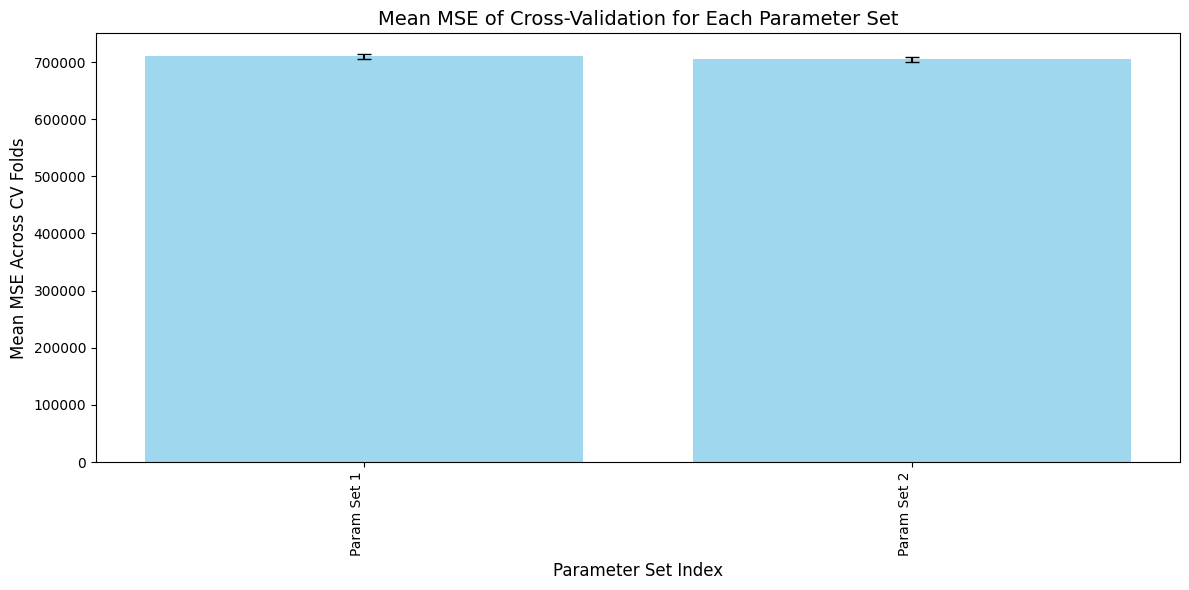

In [46]:
# Get the mean test scores for each parameter combination
mean_test_scores = grid_search_xgb.cv_results_['mean_test_score']
std_test_scores = grid_search_xgb.cv_results_['std_test_score']

# Convert negative MSE to positive MSE for better interpretation
mean_test_scores = -mean_test_scores  # Convert negative MSE to positive
std_test_scores = std_test_scores

# Create a bar chart
x_labels = [f"Param Set {i+1}" for i in range(len(mean_test_scores))]
x_pos = np.arange(len(mean_test_scores))

plt.figure(figsize=(12, 6))
plt.bar(x_pos, mean_test_scores, yerr=std_test_scores, capsize=5, color='skyblue', alpha=0.8)

# Add labels and title
plt.xlabel("Parameter Set Index", fontsize=12)
plt.ylabel("Mean MSE Across CV Folds", fontsize=12)
plt.title("Mean MSE of Cross-Validation for Each Parameter Set", fontsize=14)
plt.xticks(x_pos, x_labels, rotation=90, ha='right', fontsize=10)
plt.tight_layout()

plt.show()

In [47]:

# Create a DataFrame to show the importance of each original feature
importance_df = pd.DataFrame({
    'Original Feature': transformed_feature_names,  # Replace with actual feature names
    'Importance': best_xg_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importance_df)

                                     Original Feature  Importance
23  customer_feedback_transformation__Customer Fee...    0.217860
27                num_transformation__Previous Claims    0.180078
29                   num_transformation__Credit Score    0.100012
24                  num_transformation__Annual Income    0.091102
0                   date_transform__Policy Start Date    0.047304
26                   num_transformation__Health Score    0.040168
21          cat_impute_transformation__Marital Status    0.023738
22              cat_impute_transformation__Occupation    0.015674
4                 age_transformation__age_range_40-50    0.014557
13      cat_transformation__Policy Type_Comprehensive    0.013415
8     cat_transformation__Education Level_High School    0.013392
16     cat_transformation__Exercise Frequency_Monthly    0.013203
25           num_transformation__Number of Dependents    0.013195
10            cat_transformation__Education Level_PhD    0.013157
5         

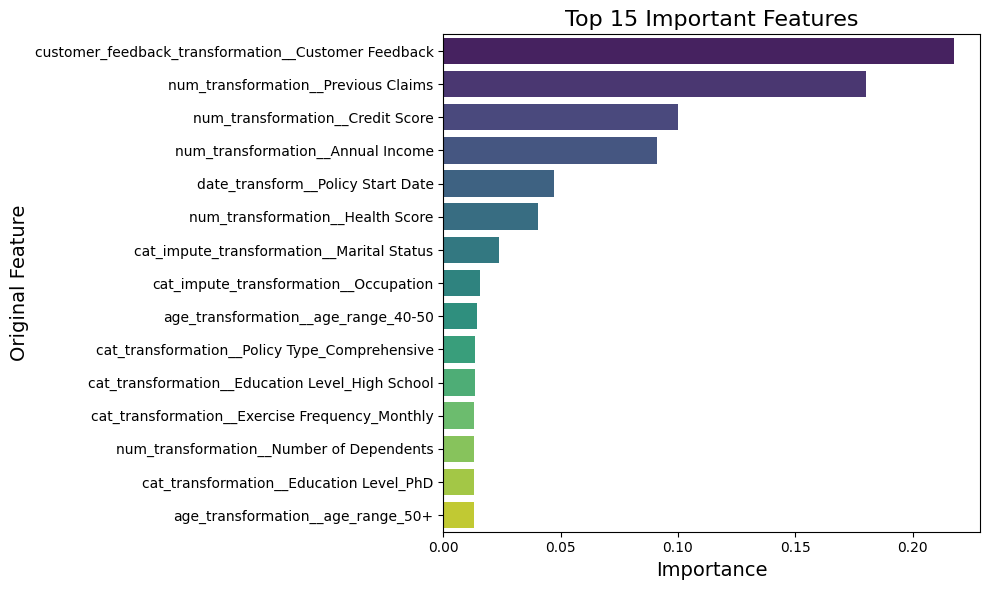

In [48]:
# Assuming the importance_df is already computed as described earlier:
# Sort the DataFrame by importance in descending order and select top 15 features
top_features = importance_df.sort_values(by='Importance', ascending=False).head(15)

# Create a horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Original Feature', data=top_features, palette='viridis')

# Add labels and title
plt.title('Top 15 Important Features', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Original Feature', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

In [49]:

# Make predictions on the test set
y_pred_xgb = best_xg_model.predict(df_test_transformed)


In [50]:
output_xgb = pd.DataFrame(y_pred_xgb, index=df_test.index, columns=['Premium Amount']).reset_index()
output_xgb['Premium Amount'] = output_xgb['Premium Amount'].round()

In [51]:
output_xgb.head()

,id,Premium Amount
0,1200000,1294.0
1,1200001,1128.0
2,1200002,1091.0
3,1200003,1105.0
4,1200004,1029.0


In [52]:
submission = output_xgb.to_csv('/kaggle/working/submission.csv', index=False)